# Installations and Dependencies

In [ ]:
# Installations
!pip install transformers
!pip install torchmetrics
!pip install torchxrayvision
!pip install pytorch-lightning
!pip install scikit-plot

In [ ]:
# File Management
from google.colab import drive
import pandas as pd

# Utilities
import tqdm
from __future__ import print_function
import argparse, random, copy
import numpy as np
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms as T
from torch.optim.lr_scheduler import StepLR

# SciKit
import sklearn
import scikitplot as skplt
from sklearn.model_selection import train_test_split

# Autoencoder Import
from transformers import AutoModel

# Preprocessing

In [ ]:
# Configure Google Drive
drive.mount('/content/gdrive', force_remount = True)

%cd "gdrive"
%cd "MyDrive"
%cd "RESEARCH - Radiological Report Generation (Troy)"
%cd "similarity"
%cd "data"

%ls

In [ ]:
# Preprocess Files
csv_df = pd.read_csv("./MS_CXR_T_temporal_image_classification_v1.0.0.csv")
csv_df.dropna(subset="pleural_effusion_progression", inplace=True)
csv_df.reset_index(drop=True, inplace=True)

prevpkl = pd.read_pickle("./prev_img.pickle")
currentpkl = pd.read_pickle("./curr_img.pickle")

# Base Architecture

In [ ]:
# Configurations for Siamese Network
config = {
    "d_model": 512,
    "dropout": 0.2,
    "num_classes": 2
}

# Siamese Network Architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        """
        The siamese network architecture makes use of two parallel neural
        networks that learn to, in this case, be able to successfully
        encode and distinguish between two images.
        """
        super(SiameseNetwork, self).__init__()
        self.resnet = AutoModel.from_pretrained('microsoft/resnet-152')

        for param in self.resnet.parameters():
            param.requires_grad = False

        outdim = 2048 * 7 * 7 * 2
        self.fc = nn.Linear(outdim, config["d_model"])
        self.relu = nn.ReLU(inplace=False)
        self.dropout = nn.Dropout(config["dropout"], inplace=False)
        self.fc_final = nn.Linear(config["d_model"], config["num_classes"])

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.last_hidden_state.view(-1, 2048*7*7)
        return output

    def forward(self, input1, input2):
        # Parallel networks in action
        prev_image_features = self.forward_once(input1)
        curr_image_features = self.forward_once(input2)

        # Combine the features, and generate the output
        image_features = torch.cat((prev_image_features, curr_image_features), 1)
        image_features = self.relu(self.fc(image_features))
        image_features = self.dropout(image_features)

        classifier_output = self.fc_final(image_features)

        return classifier_output

class SiameseDataset(Dataset):
    def __init__(self, data, prev_pkl, current_pkl):
        """
        The SiameseDataset object stores the data into something neat and accessible.
        """
        super(SiameseDataset, self).__init__()
        self.data = data
        self.prev_pkl = prev_pkl
        self.current_pkl = current_pkl

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_1 = self.prev_pkl[self.data["previous_dicom_id"][index]]
        image_2 = self.current_pkl[self.data["dicom_id"][index]]
        if self.data["pleural_effusion_progression"][index] == "stable":
          target = 0
        else:
          target = 1

        return {"prev_img": image_1, "curr_img": image_2, "change": target}

## Just to test...

In [ ]:
# Load the dataset and dataloaders

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_df, test_df = train_test_split(csv_df, shuffle=True)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_ds = SiameseDataset(train_df, prevpkl, currentpkl)
test_ds = SiameseDataset(test_df, prevpkl, currentpkl)
train_data_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_data_loader = DataLoader(test_ds, batch_size=4, shuffle=True)

# Try out one batch and see what the model spits out

batch = next(iter(train_data_loader))
batch['prev_img'] = batch['prev_img'].to(device)
batch['curr_img'] = batch['curr_img'].to(device)
batch['change'] = batch['change'].to(device)

model = SiameseNetwork().to(device)
model(batch['prev_img'], batch['curr_img'])

Some weights of the model checkpoint at microsoft/resnet-152 were not used when initializing ResNetModel: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[-0.1324, -0.0586],
        [ 0.0488, -0.1037],
        [-0.0547, -0.1626],
        [-0.0329, -0.0671]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Training and Testing

In [ ]:
def train(model, device, train_loader, optimizer, epoch):
    """
    This uses CrossEntropyLoss. Although BinaryEntropyLoss function could
    also be used, the documentation preferred using CrossEntropyLoss.

    Other than that, this is essentially training the model.
    """
    model.train()
    criterion = nn.CrossEntropyLoss()

    for batch_idx, batch in enumerate(tqdm.tqdm(train_loader)):
        targets = batch["change"].type(torch.LongTensor)

        images_1 = batch["prev_img"].to(device)
        images_2 = batch["curr_img"].to(device)
        targets = batch["change"].to(device)

        optimizer.zero_grad()
        outputs = model(images_1, images_2)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images_1), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    """
    This function tells the accuracy and loss of the model.
    """
    model.eval()
    test_loss = 0
    correct = 0

    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for batch in test_loader:
            targets = batch["change"].type(torch.LongTensor)
            images_1 = batch["prev_img"].to(device)
            images_2 = batch["curr_img"].to(device)
            targets = batch["change"].to(device)

            outputs = model(images_1, images_2)
            test_loss += criterion(outputs, targets).sum().item()
            pred = outputs.argmax(1)
            correct += pred.eq(targets).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

"""
------------- RUN THE TRAIN-TEST LOOP -------------
"""

# Load dataset pt. 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_df, test_df = train_test_split(csv_df, shuffle=True)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_ds = SiameseDataset(train_df, prevpkl, currentpkl)
test_ds = SiameseDataset(test_df, prevpkl, currentpkl)
train_data_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
test_data_loader = DataLoader(test_ds, batch_size=4, shuffle=True)

# Train-test Loop
model = SiameseNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

epochs = 100
for epoch in range(1, epochs + 1):
    train(model, device, train_data_loader, optimizer, epoch)
    test(model, device, test_data_loader)

Some weights of the model checkpoint at microsoft/resnet-152 were not used when initializing ResNetModel: ['classifier.1.bias', 'classifier.1.weight']
- This IS expected if you are initializing ResNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ResNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  1%|▏         | 1/77 [00:00<00:13,  5.78it/s]

Train Epoch: 1 [0/308 (0%)]	Loss: 0.675741


100%|██████████| 77/77 [00:09<00:00,  8.50it/s]



Test set: Average loss: 0.1736, Accuracy: 56/103 (54%)



  1%|▏         | 1/77 [00:00<00:08,  8.46it/s]

Train Epoch: 2 [0/308 (0%)]	Loss: 0.551074


100%|██████████| 77/77 [00:09<00:00,  8.51it/s]



Test set: Average loss: 0.1859, Accuracy: 55/103 (53%)



  1%|▏         | 1/77 [00:00<00:09,  8.39it/s]

Train Epoch: 3 [0/308 (0%)]	Loss: 0.394248


100%|██████████| 77/77 [00:09<00:00,  8.45it/s]



Test set: Average loss: 0.2512, Accuracy: 52/103 (50%)



  1%|▏         | 1/77 [00:00<00:09,  8.43it/s]

Train Epoch: 4 [0/308 (0%)]	Loss: 0.677015


100%|██████████| 77/77 [00:08<00:00,  8.59it/s]



Test set: Average loss: 0.1918, Accuracy: 58/103 (56%)



  1%|▏         | 1/77 [00:00<00:08,  8.55it/s]

Train Epoch: 5 [0/308 (0%)]	Loss: 0.150130


100%|██████████| 77/77 [00:09<00:00,  8.52it/s]



Test set: Average loss: 0.2083, Accuracy: 55/103 (53%)



  1%|▏         | 1/77 [00:00<00:08,  8.55it/s]

Train Epoch: 6 [0/308 (0%)]	Loss: 0.147973


100%|██████████| 77/77 [00:09<00:00,  8.52it/s]



Test set: Average loss: 0.2605, Accuracy: 56/103 (54%)



  1%|▏         | 1/77 [00:00<00:08,  8.62it/s]

Train Epoch: 7 [0/308 (0%)]	Loss: 0.078684


100%|██████████| 77/77 [00:08<00:00,  8.70it/s]



Test set: Average loss: 0.2204, Accuracy: 57/103 (55%)



  1%|▏         | 1/77 [00:00<00:08,  8.68it/s]

Train Epoch: 8 [0/308 (0%)]	Loss: 0.098934


100%|██████████| 77/77 [00:08<00:00,  8.73it/s]



Test set: Average loss: 0.2453, Accuracy: 55/103 (53%)



  1%|▏         | 1/77 [00:00<00:08,  8.59it/s]

Train Epoch: 9 [0/308 (0%)]	Loss: 0.007871


100%|██████████| 77/77 [00:09<00:00,  8.48it/s]



Test set: Average loss: 0.2761, Accuracy: 49/103 (48%)



  1%|▏         | 1/77 [00:00<00:08,  8.64it/s]

Train Epoch: 10 [0/308 (0%)]	Loss: 0.008194


100%|██████████| 77/77 [00:09<00:00,  8.45it/s]



Test set: Average loss: 0.2603, Accuracy: 51/103 (50%)



  1%|▏         | 1/77 [00:00<00:08,  8.54it/s]

Train Epoch: 11 [0/308 (0%)]	Loss: 0.011342


100%|██████████| 77/77 [00:08<00:00,  8.60it/s]



Test set: Average loss: 0.2586, Accuracy: 57/103 (55%)



  1%|▏         | 1/77 [00:00<00:10,  7.07it/s]

Train Epoch: 12 [0/308 (0%)]	Loss: 0.001809


100%|██████████| 77/77 [00:08<00:00,  8.57it/s]



Test set: Average loss: 0.2340, Accuracy: 56/103 (54%)



  1%|▏         | 1/77 [00:00<00:09,  8.35it/s]

Train Epoch: 13 [0/308 (0%)]	Loss: 0.002412


100%|██████████| 77/77 [00:09<00:00,  8.50it/s]



Test set: Average loss: 0.2935, Accuracy: 51/103 (50%)



  1%|▏         | 1/77 [00:00<00:08,  8.66it/s]

Train Epoch: 14 [0/308 (0%)]	Loss: 0.004865


100%|██████████| 77/77 [00:09<00:00,  8.52it/s]



Test set: Average loss: 0.3010, Accuracy: 52/103 (50%)



  1%|▏         | 1/77 [00:00<00:08,  8.45it/s]

Train Epoch: 15 [0/308 (0%)]	Loss: 0.003529


100%|██████████| 77/77 [00:08<00:00,  8.65it/s]



Test set: Average loss: 0.2510, Accuracy: 61/103 (59%)



  1%|▏         | 1/77 [00:00<00:09,  7.63it/s]

Train Epoch: 16 [0/308 (0%)]	Loss: 0.015357


100%|██████████| 77/77 [00:08<00:00,  8.58it/s]



Test set: Average loss: 0.3038, Accuracy: 57/103 (55%)



  1%|▏         | 1/77 [00:00<00:08,  8.54it/s]

Train Epoch: 17 [0/308 (0%)]	Loss: 0.000622


100%|██████████| 77/77 [00:09<00:00,  8.53it/s]



Test set: Average loss: 0.2975, Accuracy: 53/103 (51%)



  1%|▏         | 1/77 [00:00<00:08,  8.53it/s]

Train Epoch: 18 [0/308 (0%)]	Loss: 0.001346


100%|██████████| 77/77 [00:09<00:00,  8.53it/s]



Test set: Average loss: 0.2487, Accuracy: 57/103 (55%)



  1%|▏         | 1/77 [00:00<00:08,  8.52it/s]

Train Epoch: 19 [0/308 (0%)]	Loss: 0.051539


100%|██████████| 77/77 [00:08<00:00,  8.66it/s]



Test set: Average loss: 0.2402, Accuracy: 56/103 (54%)



  1%|▏         | 1/77 [00:00<00:10,  7.53it/s]

Train Epoch: 20 [0/308 (0%)]	Loss: 0.001037


100%|██████████| 77/77 [00:09<00:00,  8.54it/s]



Test set: Average loss: 0.2837, Accuracy: 58/103 (56%)



  1%|▏         | 1/77 [00:00<00:08,  8.60it/s]

Train Epoch: 21 [0/308 (0%)]	Loss: 0.001297


100%|██████████| 77/77 [00:09<00:00,  8.51it/s]



Test set: Average loss: 0.2743, Accuracy: 58/103 (56%)



  1%|▏         | 1/77 [00:00<00:08,  8.46it/s]

Train Epoch: 22 [0/308 (0%)]	Loss: 0.000150


100%|██████████| 77/77 [00:09<00:00,  8.13it/s]



Test set: Average loss: 0.2502, Accuracy: 58/103 (56%)



  1%|▏         | 1/77 [00:00<00:08,  8.62it/s]

Train Epoch: 23 [0/308 (0%)]	Loss: 0.013527


100%|██████████| 77/77 [00:08<00:00,  8.65it/s]



Test set: Average loss: 0.2975, Accuracy: 57/103 (55%)



  1%|▏         | 1/77 [00:00<00:10,  7.44it/s]

Train Epoch: 24 [0/308 (0%)]	Loss: 0.055447


100%|██████████| 77/77 [00:09<00:00,  8.51it/s]



Test set: Average loss: 0.2727, Accuracy: 55/103 (53%)



  1%|▏         | 1/77 [00:00<00:08,  8.55it/s]

Train Epoch: 25 [0/308 (0%)]	Loss: 0.000611


100%|██████████| 77/77 [00:09<00:00,  8.52it/s]



Test set: Average loss: 0.2493, Accuracy: 59/103 (57%)



  1%|▏         | 1/77 [00:00<00:08,  8.66it/s]

Train Epoch: 26 [0/308 (0%)]	Loss: 0.000522


100%|██████████| 77/77 [00:09<00:00,  8.49it/s]



Test set: Average loss: 0.3009, Accuracy: 55/103 (53%)



  1%|▏         | 1/77 [00:00<00:08,  8.53it/s]

Train Epoch: 27 [0/308 (0%)]	Loss: 0.009623


100%|██████████| 77/77 [00:08<00:00,  8.65it/s]



Test set: Average loss: 0.3306, Accuracy: 51/103 (50%)



  1%|▏         | 1/77 [00:00<00:08,  8.48it/s]

Train Epoch: 28 [0/308 (0%)]	Loss: 0.017790


100%|██████████| 77/77 [00:09<00:00,  8.52it/s]



Test set: Average loss: 0.3891, Accuracy: 49/103 (48%)



  1%|▏         | 1/77 [00:00<00:08,  8.52it/s]

Train Epoch: 29 [0/308 (0%)]	Loss: 0.000063


100%|██████████| 77/77 [00:09<00:00,  8.45it/s]



Test set: Average loss: 0.4937, Accuracy: 45/103 (44%)



  1%|▏         | 1/77 [00:00<00:08,  8.47it/s]

Train Epoch: 30 [0/308 (0%)]	Loss: 0.015458


100%|██████████| 77/77 [00:09<00:00,  8.53it/s]



Test set: Average loss: 0.3346, Accuracy: 53/103 (51%)



  1%|▏         | 1/77 [00:00<00:09,  8.31it/s]

Train Epoch: 31 [0/308 (0%)]	Loss: 0.000099


100%|██████████| 77/77 [00:08<00:00,  8.64it/s]



Test set: Average loss: 0.3109, Accuracy: 59/103 (57%)



  1%|▏         | 1/77 [00:00<00:08,  8.55it/s]

Train Epoch: 32 [0/308 (0%)]	Loss: 0.015681


100%|██████████| 77/77 [00:09<00:00,  8.53it/s]



Test set: Average loss: 0.3619, Accuracy: 47/103 (46%)



  1%|▏         | 1/77 [00:00<00:08,  8.58it/s]

Train Epoch: 33 [0/308 (0%)]	Loss: 0.002655


100%|██████████| 77/77 [00:09<00:00,  8.53it/s]



Test set: Average loss: 0.4414, Accuracy: 58/103 (56%)



  1%|▏         | 1/77 [00:00<00:09,  8.37it/s]

Train Epoch: 34 [0/308 (0%)]	Loss: 0.000025


100%|██████████| 77/77 [00:08<00:00,  8.61it/s]



Test set: Average loss: 0.3853, Accuracy: 56/103 (54%)



  1%|▏         | 1/77 [00:00<00:08,  8.60it/s]

Train Epoch: 35 [0/308 (0%)]	Loss: 0.000184


100%|██████████| 77/77 [00:08<00:00,  8.69it/s]



Test set: Average loss: 0.4329, Accuracy: 59/103 (57%)



  1%|▏         | 1/77 [00:00<00:08,  8.47it/s]

Train Epoch: 36 [0/308 (0%)]	Loss: 0.001572


100%|██████████| 77/77 [00:08<00:00,  8.56it/s]



Test set: Average loss: 0.4009, Accuracy: 55/103 (53%)



  1%|▏         | 1/77 [00:00<00:08,  8.63it/s]

Train Epoch: 37 [0/308 (0%)]	Loss: 0.005627


100%|██████████| 77/77 [00:09<00:00,  8.53it/s]



Test set: Average loss: 0.3480, Accuracy: 63/103 (61%)



  1%|▏         | 1/77 [00:00<00:09,  8.28it/s]

Train Epoch: 38 [0/308 (0%)]	Loss: 0.002808


100%|██████████| 77/77 [00:08<00:00,  8.61it/s]



Test set: Average loss: 0.4465, Accuracy: 58/103 (56%)



  1%|▏         | 1/77 [00:00<00:08,  8.68it/s]

Train Epoch: 39 [0/308 (0%)]	Loss: 0.013130


100%|██████████| 77/77 [00:08<00:00,  8.68it/s]



Test set: Average loss: 0.3732, Accuracy: 55/103 (53%)



  1%|▏         | 1/77 [00:00<00:09,  8.39it/s]

Train Epoch: 40 [0/308 (0%)]	Loss: 0.001320


100%|██████████| 77/77 [00:09<00:00,  8.54it/s]



Test set: Average loss: 0.4953, Accuracy: 55/103 (53%)



  1%|▏         | 1/77 [00:00<00:08,  8.71it/s]

Train Epoch: 41 [0/308 (0%)]	Loss: 0.000037


100%|██████████| 77/77 [00:09<00:00,  8.55it/s]



Test set: Average loss: 0.4217, Accuracy: 46/103 (45%)



  1%|▏         | 1/77 [00:00<00:08,  8.49it/s]

Train Epoch: 42 [0/308 (0%)]	Loss: 0.000038


100%|██████████| 77/77 [00:08<00:00,  8.62it/s]



Test set: Average loss: 0.4791, Accuracy: 57/103 (55%)



  1%|▏         | 1/77 [00:00<00:10,  7.59it/s]

Train Epoch: 43 [0/308 (0%)]	Loss: 0.000076


100%|██████████| 77/77 [00:08<00:00,  8.65it/s]



Test set: Average loss: 0.4028, Accuracy: 54/103 (52%)



  1%|▏         | 1/77 [00:00<00:08,  8.52it/s]

Train Epoch: 44 [0/308 (0%)]	Loss: 0.000005


 47%|████▋     | 36/77 [00:04<00:04,  8.27it/s]


KeyboardInterrupt: ignored

# Prediction Generation

In [ ]:
def predict(prev_img, curr_img, convert=True):
    """
    Translates to make model prediction readable
    """
    prv_img = prev_img.unsqueeze(0).to(device)
    crr_img = curr_img.unsqueeze(0).to(device)
    m = torch.nn.Sigmoid()
    pred = m(model(prv_img, crr_img))

    if convert:
      pred = pred.argmax(1)
      if pred == 0:
        return "no change"
      else:
        return "changed"

    return pred

Reference: worsening (changed)
Generated: changed


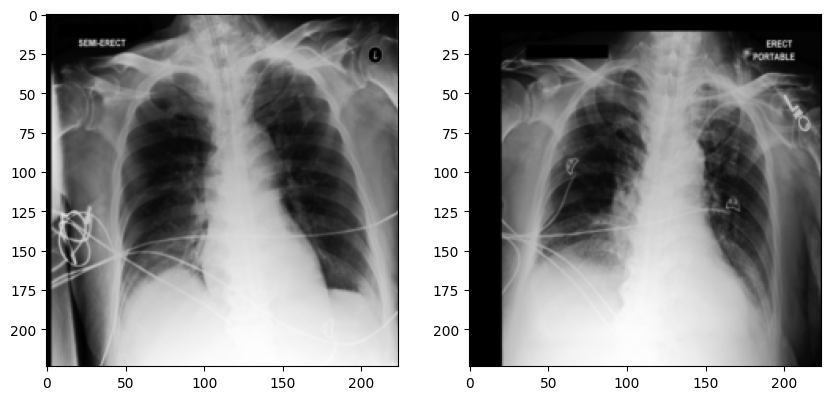

In [ ]:
"""
This block of code gives out sample two images, and tests out how the model reacts
"""

row = test_df.iloc[random.randint(0, len(test_df)-1)]
prev_img = prevpkl[row.previous_dicom_id]
curr_img = currentpkl[row.dicom_id]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(torch.permute(prev_img, (1, 2, 0)))
ax[1].imshow(torch.permute(curr_img, (1, 2, 0)))

progression_dict = {"stable": "no change", "worsening": "changed", "improving": "changed"}

pe = row['pleural_effusion_progression']
print(f"Reference: {pe} ({progression_dict[pe]})")
print(f"Generated: {predict(prev_img, curr_img)}")

# Performance Evaluation

In [ ]:
"""
This block of code just gets the, as I like to call it, "expectation vs reality"
In other words, it gets how good the model is at identifying n=2 classes.
"""
y_true = []
y_prob = []

for i in range(len(test_df)):
  row = test_df.iloc[i]

  if progression_dict[row["pleural_effusion_progression"]] == "no change":
    y_true.append(0)
  else:
    y_true.append(1)
  # if progression_dict[row["pleural_effusion_progression"]] != "no change":
  #   y_true.append(1)

  prev_img = prevpkl[row.previous_dicom_id]
  curr_img = currentpkl[row.dicom_id]
  y_prob.append(predict(prev_img, curr_img, convert=False)[0][y_true[-1]].item())

print(y_true, len(y_true))
print(y_prob, len(y_prob))

[1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1] 103
[0.5604159235954285, 0.6281354427337646, 0.2649059593677521, 0.47309380769729614, 0.22131262719631195, 0.05128083750605583, 0.09325078129768372, 0.5046370029449463, 0.8681051731109619, 0.2601662278175354, 0.9222996830940247, 0.9583246111869812, 0.4437229037284851, 0.7391126751899719, 0.2256474494934082, 0.14631454646587372, 0.554497480392456, 0.26757198572158813, 0.48491501808166504, 0.7771949172019958, 0.8703283071517944, 0.09148350358009338, 0.9088346362113953, 0.4394013583660126, 0.41923192143440247, 0.9006018042564392, 0.30311715602874756, 0.5731056928634644, 0.75214684009552, 0.8204410076141357, 0.7344381213188171, 0.5671225786209106, 0.4418673515319824, 0.0793366432189941

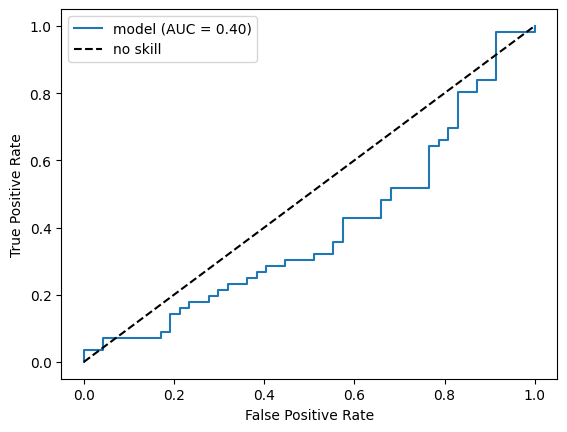

In [ ]:
"""
Graph AUC score so we can visually understand it (the model's pretty bad)
"""

actual_auc_score = sklearn.metrics.roc_auc_score(y_true, y_prob)
fpr, tpr, thresholds = skplt.metrics.roc_curve(y_true, y_prob)

plt.plot(fpr,tpr, label="model (AUC = {:.2f})".format(actual_auc_score))
plt.plot([0, 1], [0, 1], "k--", label="no skill")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend()
plt.show()